In [1]:
import xarray as xr
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import torchvision 
import pandas as pd
import seaborn as sns
import os 

ROOT = os.getenv('MB_ROOT_PATH')
sys.path.append(ROOT)

from tools.processing import *
from tools.loading import *
RESULTS_PATH = ''


 # Plot Distributions

In [2]:
def get_activations_iden(dataset, model_info):
    
    model_name = model_info['iden']
    
    if model_info['max_pool']:
        model_name = model_name + '_mp' 

    activations_identifier = model_name + '_' + f'{model_info["num_layers"]}_layers' + '_' + f'{model_info["num_features"]}_features' 

    if model_info['pca']:
        activations_identifier = activations_identifier + '_' + f'{model_info["num_pca_components"]}' + '_'  + f'{model_info["pca_dataset"]}' + '_' + 'pcs' 

    return activations_identifier + '_' + dataset


def get_scores_iden(activations_identifier, region, mode, alpha):
    
    scores_identifier = activations_identifier + '_' + region + '_' + mode + '_' + f'ridge(alpha={alpha})' 
    return scores_identifier


In [3]:
from matplotlib import rcParams

# figure size in inches

def plot_data_dist(data_dict,legend_name_dict,file_name,show_legend=False):

    root_path = '/data/atlas/model_scores'
    df = pd.DataFrame()
    rcParams['figure.figsize'] = 6, 4
    
    index = 0
  
    for model_name, model_info in data_dict.items():
        
            regression = Ridge(alpha=model_info["alpha"]) 

            data = xr.open_dataset(os.path.join(root_path,f'{model_name}_{regression}'))
            r = list(data.r_value.values)
            df_tmp =  pd.DataFrame({'mean_score':r,
                                    'alpha':[model_info["alpha"] for i in range(len(data.r_value))],
                                    'model':[model_name for i in range(len(data.r_value))]})
            df = pd.concat([df,df_tmp])

            #index+=1
    
    if legend_name_dict is not None:
        df.model = df.model.map(legend_name_dict)
    
    sns.violinplot(data=df,x='model',y='mean_score',height=4,aspect=8/4)#,palette=palette) #,
    
    plt.ylabel(ylabel='Correlation (Pearson r)')        
    if file_name is not None:
        plt.savefig(f'{file_name}.png')
    


# Plot Means 

In [12]:
from matplotlib import rcParams

# figure size in inches

def plot_data_means(data_dict, dataset, region, mode, file_name,show_legend=False):

    root_path = '/data/atlas/model_scores'
    df = pd.DataFrame()
    rcParams['figure.figsize'] = 6, 4
    
    index = 0
  
    for model_name, model_info in data_dict.items():
        
        for alpha in model_info['alphas']:
            regression = f'Ridge(alpha={alpha})' 

            activations_iden = get_activations_iden(dataset, model_info)
            scores_iden = get_scores_iden(activations_iden, region, mode, alpha)
            
            data = xr.open_dataset(os.path.join(root_path,activations_iden,scores_iden))
            mean_r = np.mean(data.r_value.values)
            df_tmp =  pd.DataFrame({'score':mean_r,
                                    'alpha':str(alpha),
                                    'model':model_name},index=[index])
            df = pd.concat([df,df_tmp])

            index+=1
    
    
    sns.relplot(data=df,x='model',y='score',hue='alpha',height=5,aspect=10/4)#,palette=palette) #,
    
    plt.ylabel(ylabel='Correlation (Pearson r)')        
    if file_name is not None:
        plt.savefig(f'{file_name}.png')
    


In [5]:
from matplotlib import rcParams

# figure size in inches

def plot_subject_means(data_dict,file_name,aspect,palette,show_legend=False):

    # sns.axes_style()
    # sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    root_path = '/data/atlas/model_scores'
    df = pd.DataFrame()
    
  
    c= 0
    for model_name, model_info in data_dict.items():
        
        
            regression = f'Ridge(alpha={model_info["alpha"]})' 

            data = xr.open_dataset(os.path.join(root_path,f'{model_name}_{regression}'))
    
            r_vals = data.groupby('subject').mean().r_value 

            df_tmp =  pd.DataFrame({'mean_score':r_vals,
                                'model':[model_info['name'] for i in range(len(r_vals))],
                                'model_num':[c for i in range(len(r_vals))],
                               'alpha':[model_info["alpha"] for i in range(len(r_vals))]}) 
            df = pd.concat([df,df_tmp])
            c += 1


    df['jitter'] = df['model_num'].apply(lambda x:  np.random.normal(x, 0.06))
   
    
    
    #return df
    sns.relplot(data=df,x='jitter',y='mean_score',hue='model',alpha=0.5,s=100,height=6, aspect =aspect,palette=palette)
    sns.boxplot(data = df, x='model', y = "mean_score", color='white',showfliers = False)
    #plt.plot(legend=None)  
    
    plt.rc('xtick', labelsize=23) 
    plt.rc('ytick', labelsize=15) 
    plt.xlabel(xlabel = '',fontsize=18)
    plt.ylabel('Correlation (Pearson r)', fontsize=18)
    plt.ylim(0,0.32)

    #sns.set(rc={'figure.figsize':(12,12)})
    
    if file_name is not None:
        plt.savefig(f'{file_name}.png') 

plt.figure(figsize=(10,6))
# Monkey V4 & IT

In [ ]:
activations_data = xr.open_dataset(os.path.join('/data/atlas/activations/alexnet_untrained_mp_majajhong'))    

activations_data = torch.Tensor(activations_data.sortby('stimulus_id', ascending=True)['x'].values)
activations_data.shape

torch.Size([3200, 256])

In [56]:
activations_data.shape

torch.Size([3200, 9216])

In [5]:

# data_dict = {
#     'model_final_mp_majajhong':['V4','IT'],
#     'alexnet_mp_majajhong':['V4','IT'],
#     'alexnet_untrained_mp_majajhong':['V4','IT'],
    
# }

# legend_name_dict = {
#                     'model_final_mp_majajhong':'model',
#                     'alexnet_mp_majajhong':'alexnet',
#                     'alexnet_untrained_mp_majajhong':'alexnet untrained',
    
#                    }



# file_name = None#'majajhong_brainscore'

# plot_data(data_dict,legend_name_dict,file_name,palette=None,regression='Ridge(alpha=0)',subject=None,show_legend=True)



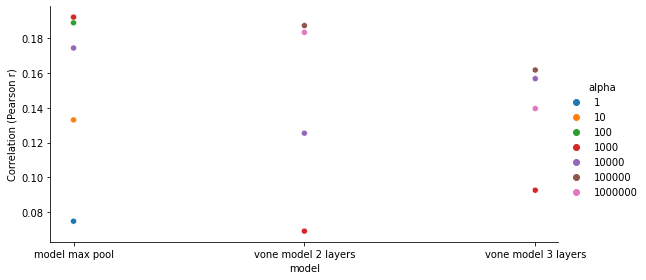

In [8]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'train'

data_dict = {
        
            'model max pool':{
                'iden':'model',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[10**i for i in range(5)],
                },
    
    
            'vone model 2 layers':{
                'iden':'model_vone',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessRGB, 
                'num_layers':2,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[10**i for i in range(3,7)],
            },
    
            'vone model 3 layers':{
                'iden':'model_vone',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[10**i for i in range(3,7)],
            }

    }    


plot_data_means(data_dict, dataset, region, mode, file_name='vone model',show_legend=True)

In [13]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'train'

data_dict = {
            'alexnet u wide 256 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'num_pca_components':256,
                'pca_dataset':'nsd',
                'max_pool':False,
                'alphas':[0] + [10**i for i in range(5)],
                }, 
    
            'alexnet u wide maxpool':{
                'iden':'alexnet_u_wide',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[0] + [10**i for i in range(3)],
                },      
    
             'model max pool':{
                'iden':'model',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[10**i for i in range(5)],
                'name':'alexnet_u_wide_maxpool'
                },  
    }    


plot_data_means(data_dict, dataset, region, mode, file_name='alexnet wide untrained',show_legend=False)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/atlas/model_scores/alexnet_u_wide_5_layers_10000_features_256_nsd_pcs_naturalscenes/alexnet_u_wide_5_layers_10000_features_256_nsd_pcs_naturalscenes_V4_train_ridge(alpha=10000)'

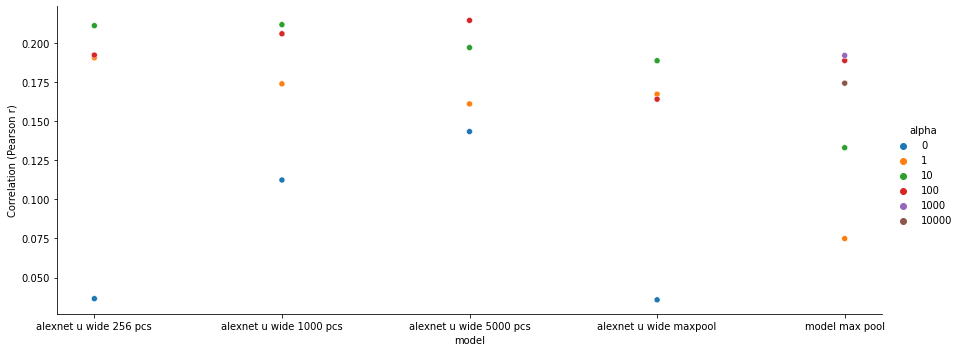

In [14]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'train'

data_dict = {
            'alexnet u wide 256 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'num_pca_components':256,
                'pca_dataset':'nsd',
                'max_pool':False,
                'alphas':[0] + [10**i for i in range(3)],
                }, 
    
            'alexnet u wide 1000 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'num_pca_components':1000,
                'pca_dataset':'nsd',
                'max_pool':False,
                'alphas':[0] + [10**i for i in range(3)],
                },     
    
            'alexnet u wide 5000 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'num_pca_components':5000,
                'pca_dataset':'nsd',
                'max_pool':False,
                'alphas':[0] + [10**i for i in range(3)],
                },  
    
            'alexnet u wide maxpool':{
                'iden':'alexnet_u_wide',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[0] + [10**i for i in range(3)],
                },      
    
             'model max pool':{
                'iden':'model',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                'max_pool':True,
                'alphas':[10**i for i in range(5)],
                'name':'alexnet_u_wide_maxpool'
                },  
    }    


plot_data_means(data_dict, dataset, region, mode, file_name='alexnet wide untrained',show_legend=False)

In [56]:


file = open('/data/atlas/pca_mp/alexnet_u_wide_pca_5000_naturalscenes', 'rb')
_pca = pickle.load(file)  
_pca.components_.shape

(5000, 10000)

# NSD

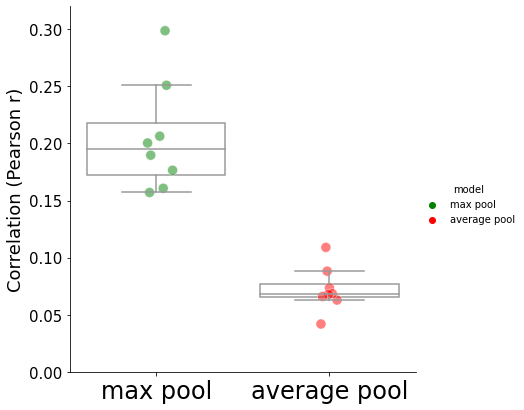

In [28]:
dataset = 'naturalscenes_zscored_processed'
region = 'V4'
mode = 'test'
palette = {'max pool':'green', 'average pool':'red'}

data_dict = {
         f'model_3L_mp_10000_{dataset}_{region}_{mode}':{'alpha':1000,'name':'max pool'},
         f'model_3L_mp_10000_avgpool_{dataset}_{region}_{mode}':{'alpha':100,'name':'average pool'},

}
        
        
file_name = 'max_pool_vs_avg_pool'


plot_subject_means(data_dict,file_name,aspect=1,palette=palette,show_legend='max vs avgpool')

In [ ]:

ROOT_PATH = '/data/atlas/model_scores'
BEST_ALPHA_PATH = '/data/atlas/regression_alphas'    
RESULTS_PATH = '' 

file = open(os.path.join(BEST_ALPHA_PATH,f'{model_info["alpha_file_name"]}_{dataset}_{region}'),'rb')
best_alphas = pickle.load(file)
alpha = best_alphas[model_name]

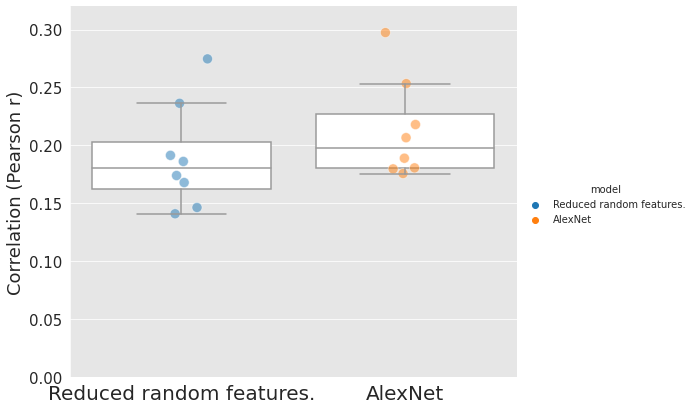

In [11]:
dataset = 'naturalscenes_zscored_processed'
region = 'V4'
mode = 'test'

data_dict = {
         f'model_3L_mp_10000_nsd_pca_{dataset}_256_{region}_{mode}':{'alpha':100,'name':'Reduced random features.'},
         f'alexnet_mp_{dataset}_{region}_{mode}':{'alpha':100000,'name':'AlexNet'},

}
        
        
file_name = 'alexnet vs model pca '


plot_subject_means(data_dict,file_name,aspect=1.25,show_legend='max vs avgpool')




# Object2vec

In [62]:
data_dict = {'name':'object2vec','regions':['roi_EVC','roi_LOC']}
plot_data(data_dict)

TypeError: plot_data() missing 4 required positional arguments: 'legend_name_dict', 'file_name', 'alpha', and 'palette'

In [63]:
i = 0
batch= 100
l = []
activations_path = '/data/atlas/activations'
dataset = 'naturalscenes_zscored_processed'
model_name = 'engineered_model_final_100000'
activations_identifier = model_name + '_' + dataset



In [64]:
#################
shared_ids = list(xr.open_dataset('/data/atlas/activations/alexnet_naturalscenes').stimulus_id.values)

i = 0
batch= 100
l_test = []
for r in range(730):

    batch_activations = xr.open_dataset(os.path.join(activations_path,
                                                     f'{activations_identifier}_{i}_{i+batch}'))
    batch_test = batch_activations.where(batch_activations.stimulus_id.isin(shared_ids),drop=True)
    l_test.append(batch_test)
    i += batch
    print(i)

IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

In [ ]:
X_test = xr.concat(l_test,dim='presentation')
#######################
X_test = torch.Tensor(X_test['x'].values)
print(len(X_test))

In [ ]:
import torch 
import torchvision
alexnetmodel_1 = torchvision.models.alexnet(pretrained=False)
alexnetmodel = torchvision.models.alexnet(weights= None)


def _initialize_random(layer: torch.nn.Module, seed: int = 0) -> None:
    torch.manual_seed(seed)
    if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
        if layer.bias is not None:
            layer.bias.data.fill_(0.01)

In [ ]:
alexnetmodel_1

In [6]:
alexnetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 